# Exploratory Data Analysis (EDA)

Python notebook re: visualizations and descriptive stats; missingness analysis; correlation heatmaps, scatterplots, outlier checks

Main output(s): 
- features_emg_data_cleaned.csv: cleaned dataset with outliers removed, ready for feature selection

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-10-21

## Import libraries

In [1]:
# Core data handling - basic packages
import numpy as np
import pandas as pd
import warnings
import os

# Visualization - simple plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics - basic stats functions
from scipy import stats

# Machine learning - only what we need
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler

# Make results repeatable
RANDOM_STATE = 13
np.random.seed(RANDOM_STATE)

## Load and inspect data

In [2]:
# Load data file
data_file = "../../emg_data/features_emg_data.csv"

df = pd.read_csv(data_file)
print(f"Data shape: {df.shape}")  # rows, columns

# Remove unnecessary index columns
columns_to_drop = ['Unnamed: 0', 'index', 'Unnamed: 0.1']  # add common variations
df_clean = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

print(f"After removing index columns: {df_clean.shape}")

# Double-check that unwanted columns are gone
remaining_cols = df_clean.columns.tolist()
unwanted_in_remaining = [col for col in columns_to_drop if col in remaining_cols]
if unwanted_in_remaining:
    print(f"WARNING: These columns still exist: {unwanted_in_remaining}")
    df_clean = df_clean.drop(columns=unwanted_in_remaining)

print(f"Final shape after cleanup: {df_clean.shape}")

Data shape: (139377, 165)
After removing index columns: (139377, 163)
Final shape after cleanup: (139377, 163)


In [3]:
# See what the data looks like now
df_clean.head(5)

,ch00_rms,ch01_rms,ch02_rms,ch03_rms,ch04_rms,ch05_rms,ch06_rms,ch07_rms,ch08_rms,ch09_rms,...,ch09_thresh2-events,ch10_thresh2-events,ch11_thresh2-events,ch12_thresh2-events,ch13_thresh2-events,ch14_thresh2-events,ch15_thresh2-events,gesture,stage,user
0,9.989673,12.824719,19.425159,32.592478,29.791715,19.048967,12.083390,9.291876,9.474774,12.034365,...,2.0,2.0,1.0,6.0,4.0,5.0,4.0,index_press,pinch_release_static_hand_in_lap_with_taps,19
1,23.066061,23.888872,35.386110,39.688074,28.867694,20.743550,13.941204,11.463285,12.957853,17.214658,...,5.0,4.0,5.0,6.0,7.0,10.0,4.0,index_press,pinch_release_static_hand_in_lap_with_taps,19
2,15.647086,25.068543,43.062281,54.325056,34.475540,22.649844,15.232970,12.238017,11.391191,10.820393,...,1.0,0.0,2.0,4.0,6.0,5.0,8.0,index_press,pinch_release_static_hand_in_lap_with_taps,19
3,9.577057,12.880236,19.681067,25.718243,18.829439,16.082287,11.626173,9.934410,9.711847,10.385964,...,2.0,1.0,3.0,3.0,3.0,2.0,3.0,index_press,pinch_release_static_hand_in_lap_with_taps,19
4,28.080062,41.913348,71.097516,85.425059,55.060205,37.417092,27.184023,23.667525,23.080325,24.790593,...,9.0,6.0,6.0,9.0,8.0,9.0,9.0,index_press,pinch_release_static_hand_in_lap_with_taps,19


In [4]:
print("Column names (first 10):", df_clean.columns.tolist()[:10])

Column names (first 10): ['ch00_rms', 'ch01_rms', 'ch02_rms', 'ch03_rms', 'ch04_rms', 'ch05_rms', 'ch06_rms', 'ch07_rms', 'ch08_rms', 'ch09_rms']


In [5]:
# Check what types of data we have
print("Data types:")
print(df_clean.dtypes.value_counts())

Data types:
float64    160
object       2
int64        1
Name: count, dtype: int64


In [6]:
# Check for missing data
print(f"\nTotal missing values: {df_clean.isnull().sum().sum()}")
print("Missing values by column (top 10):")
missing_data = df_clean.isnull().sum().sort_values(ascending=False)
print(missing_data.head(10))


Total missing values: 33664
Missing values by column (top 10):
ch00_rms             263
ch01_fft-maxpower    263
ch15_fft-highfreq    263
ch14_fft-highfreq    263
ch13_fft-highfreq    263
ch12_fft-highfreq    263
ch11_fft-highfreq    263
ch10_fft-highfreq    263
ch09_fft-highfreq    263
ch08_fft-highfreq    263
dtype: int64


## Check completeness

In [7]:
# Check how many missing values we actually have
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Unnamed: 0                  0
index                  139377
ch00_rms                  263
ch01_rms                  263
ch02_rms                  263
                        ...  
ch14_thresh2-events         0
ch15_thresh2-events         0
gesture                     0
stage                       0
user                        0
Length: 165, dtype: int64


In [8]:
# Check if any rows have ALL values missing
all_missing_rows = df.isnull().all(axis=1).sum()
print(f"Rows with all values missing: {all_missing_rows}")

# Check rows with ANY missing values  
any_missing_rows = df.isnull().any(axis=1).sum()
print(f"Rows with any missing values: {any_missing_rows}")

Rows with all values missing: 0
Rows with any missing values: 139377


In [9]:
# Calculate percent completeness for each row
total_columns = df.shape[1]
non_missing_counts = df.notnull().sum(axis=1)
percent_complete = (non_missing_counts / total_columns) * 100

print(f"Mean completeness: {percent_complete.mean():.2f}%")
print(f"Median completeness: {percent_complete.median():.2f}%")
print(f"Min completeness: {percent_complete.min():.2f}%")
print(f"Max completeness: {percent_complete.max():.2f}%")

Mean completeness: 99.25%
Median completeness: 99.39%
Min completeness: 21.82%
Max completeness: 99.39%


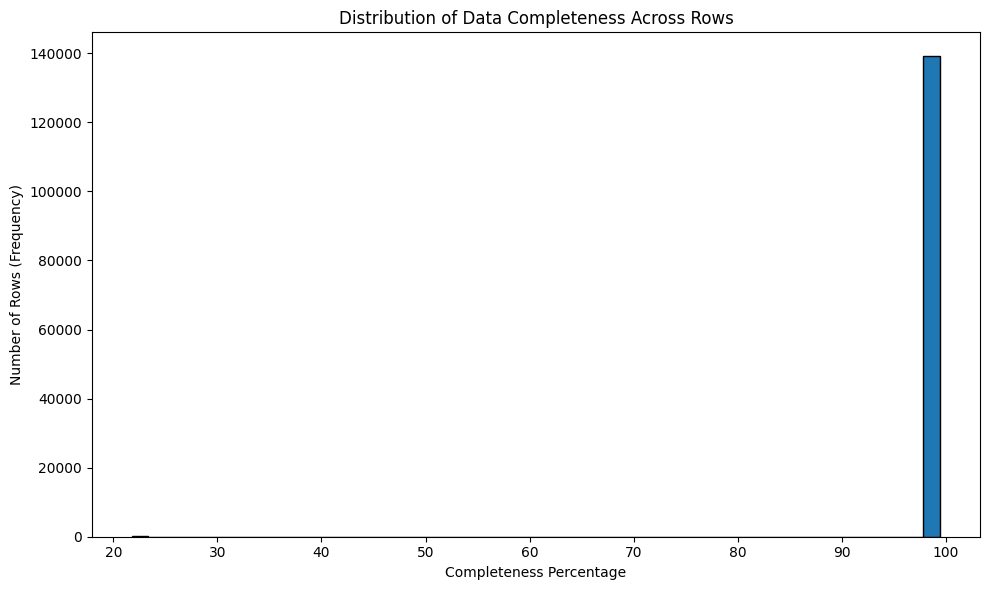

Rows 100% complete: 0 (0.00%)
Rows >95% complete: 139114 (99.81%)
Rows >90% complete: 139114 (99.81%)


In [10]:
# Visualize distribution of completeness
# use histogram to inspect distribution
plt.figure(figsize=(10, 6))

# Create histogram plot
plt.hist(percent_complete, 
         bins=50, 
         edgecolor='black') 

# label plot and axes
plt.xlabel('Completeness Percentage')
plt.ylabel('Number of Rows (Frequency)')
plt.title('Distribution of Data Completeness Across Rows')

# prevent labels from overlapping the edge of the figure
plt.tight_layout()
plt.show()

# Quantify key completeness levels

# Calculate counts for rows at key thresholds
count_100_percent = (percent_complete == 100).sum()
count_over_95_percent = (percent_complete > 95).sum()
count_over_90_percent = (percent_complete > 90).sum()

# We need the total number of original rows to calculate percentages
total_rows = len(df) 

# Calculate and print percentage for 100% complete rows
percent_100 = (count_100_percent / total_rows) * 100
print(f"Rows 100% complete: {count_100_percent} ({percent_100:.2f}%)")

# Calculate and print percentage for rows >95% complete
percent_95 = (count_over_95_percent / total_rows) * 100
print(f"Rows >95% complete: {count_over_95_percent} ({percent_95:.2f}%)")

# Calculate and print percentage for rows >90% complete
percent_90 = (count_over_90_percent / total_rows) * 100
print(f"Rows >90% complete: {count_over_90_percent} ({percent_90:.2f}%)")

## Clean the data

In [11]:
# Remove empty columns and rows
print("Before cleaning:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Remove completely empty rows
df_clean = df.dropna(how='all')

# Remove completely empty columns  
empty_cols = df_clean.columns[df_clean.isnull().all()].tolist()
if empty_cols:
    df_clean = df_clean.drop(columns=empty_cols)
    print(f"Removed {len(empty_cols)} empty column(s): {empty_cols}")

Before cleaning:
Rows: 139377, Columns: 165
Removed 1 empty column(s): ['index']


In [12]:
# Double check if any index-like columns left...
all_columns = df_clean.columns.tolist()
index_like_cols = [col for col in all_columns if any(pattern in col.lower() for pattern in ['unnamed', 'index', 'level_'])]

if index_like_cols:
    print(f"Found/removed index-like columns: {index_like_cols}")
    df_clean = df_clean.drop(columns=index_like_cols)
    print(f"New shape: {df_clean.shape}")

Found/removed index-like columns: ['Unnamed: 0']
New shape: (139377, 163)


In [13]:
# Identify different types of columns
# Metadata columns (information about the data)
metadata_cols = ['user', 'gesture', 'stage']
print(f"Metadata columns: {metadata_cols}")

# Feature columns (the measurements we'll analyze) - EXCLUDE any remaining index-like columns
all_columns = df_clean.columns.tolist()
feature_cols = [col for col in all_columns if col not in metadata_cols]

# Remove any columns that look like indices
index_like_patterns = ['unnamed', 'index', 'level_']
feature_cols = [col for col in feature_cols if not any(pattern in col.lower() for pattern in index_like_patterns)]

print(f"Total feature columns: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")

Metadata columns: ['user', 'gesture', 'stage']
Total feature columns: 160
First 10 features: ['ch00_rms', 'ch01_rms', 'ch02_rms', 'ch03_rms', 'ch04_rms', 'ch05_rms', 'ch06_rms', 'ch07_rms', 'ch08_rms', 'ch09_rms']


In [14]:
# Handle missing values in features

# Count missing values in feature columns
missing_in_features = df_clean[feature_cols].isnull().sum().sum()
print(f"Missing values in features: {missing_in_features}")

if missing_in_features > 0:
    # Fill missing values with median (middle value)
    df_clean[feature_cols] = df_clean[feature_cols].fillna(df_clean[feature_cols].median())
    
print(f"Final data shape: {df_clean.shape}")

Missing values in features: 33664
Final data shape: (139377, 163)


## Inspect data distributions

In [15]:
# Look at basic statistics
df_clean[feature_cols].describe()

,ch00_rms,ch01_rms,ch02_rms,ch03_rms,ch04_rms,ch05_rms,ch06_rms,ch07_rms,ch08_rms,ch09_rms,...,ch06_thresh2-events,ch07_thresh2-events,ch08_thresh2-events,ch09_thresh2-events,ch10_thresh2-events,ch11_thresh2-events,ch12_thresh2-events,ch13_thresh2-events,ch14_thresh2-events,ch15_thresh2-events
count,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000,...,139377.000000,139377.000000,139377.000000,139377.000000,139377.00000,139377.000000,139377.000000,139377.000000,139377.000000,139377.000000
mean,10.617541,10.515807,10.418810,11.603911,13.320736,12.830885,11.530441,11.913804,15.059290,20.859389,...,3.603600,3.910358,4.017019,3.788007,3.71204,3.713274,3.757851,3.788229,3.864088,3.970311
std,11.869122,11.498622,10.956181,16.324124,18.074324,15.448555,12.332524,11.611052,14.641727,21.833177,...,3.360496,3.318584,3.268503,3.211469,3.24509,3.229552,3.165994,3.146977,3.219454,3.266500
min,0.970693,0.949930,0.964111,1.012324,0.999803,1.019962,0.966297,1.043882,0.992280,1.064147,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.280154,4.106767,4.053530,4.041198,4.054841,4.230807,4.585284,5.196780,6.308673,7.741021,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,7.425836,7.071123,7.133839,7.025934,7.355923,7.637406,7.916622,8.687871,10.736226,13.962721,...,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,12.748886,12.587596,12.776502,12.975105,14.982634,15.105377,13.964381,14.574640,18.364008,25.899188,...,6.000000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000
max,776.963652,354.349582,446.823754,585.360620,618.243711,779.136895,415.601947,348.701565,381.415394,503.234773,...,26.000000,23.000000,25.000000,22.000000,22.00000,22.000000,20.000000,20.000000,23.000000,23.000000


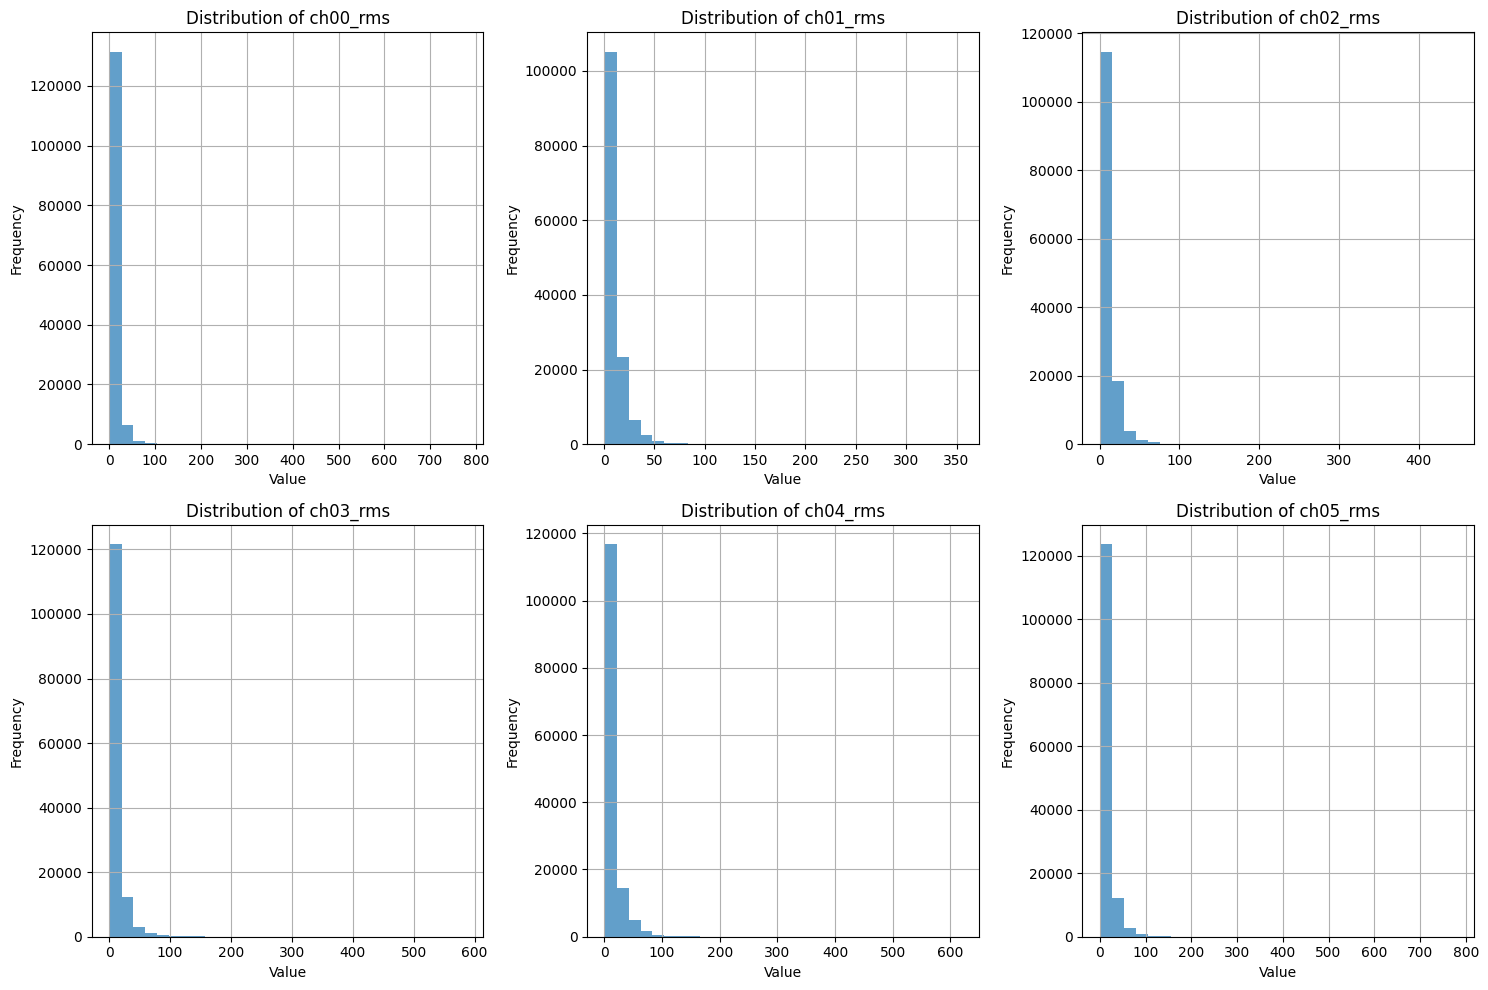

In [16]:
# Plot distributions of first 6 features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(feature_cols[:6]):
    df_clean[feature].hist(bins=30, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
# Look at our metadata
print("Users in dataset:")
print(f"Number of unique users: {df_clean['user'].nunique()}")
print(f"User IDs: {sorted(df_clean['user'].unique())[:10]}...")  # First 10

print("\nGestures in dataset:")
print(f"Number of unique gestures: {df_clean['gesture'].nunique()}")
print(f"Gesture IDs: {sorted(df_clean['gesture'].unique())}")

# Count samples per gesture
print("\nSamples per gesture:")
print(df_clean['gesture'].value_counts().sort_index())

Users in dataset:
Number of unique users: 100
User IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...

Gestures in dataset:
Number of unique gestures: 9
Gesture IDs: ['index_press', 'index_release', 'middle_press', 'middle_release', 'thumb_click', 'thumb_down', 'thumb_in', 'thumb_out', 'thumb_up']

Samples per gesture:
gesture
index_press       22460
index_release     22435
middle_press      22532
middle_release    22565
thumb_click        8326
thumb_down        10236
thumb_in          10198
thumb_out         10330
thumb_up          10295
Name: count, dtype: int64


## Check for outliers

### By scipy.stats.zscore

In [18]:
# Method 1: Z-scores (how far from average)

# Use only feature columns for analysis
X_data = df_clean[feature_cols].copy()

# Calculate Z-scores (how many standard deviations from mean)
z_scores = stats.zscore(X_data)
z_threshold = 3  # Points more than 3 standard deviations away

# Find outliers
z_outlier_flags = np.abs(z_scores) > z_threshold
z_outlier_rows = z_outlier_flags.any(axis=1)

z_outlier_count = z_outlier_rows.sum()
z_outlier_percent = (z_outlier_count / len(df_clean)) * 100

print(f"Z-score method found {z_outlier_count} outliers ({z_outlier_percent:.1f}% of data)")

Z-score method found 55901 outliers (40.1% of data)


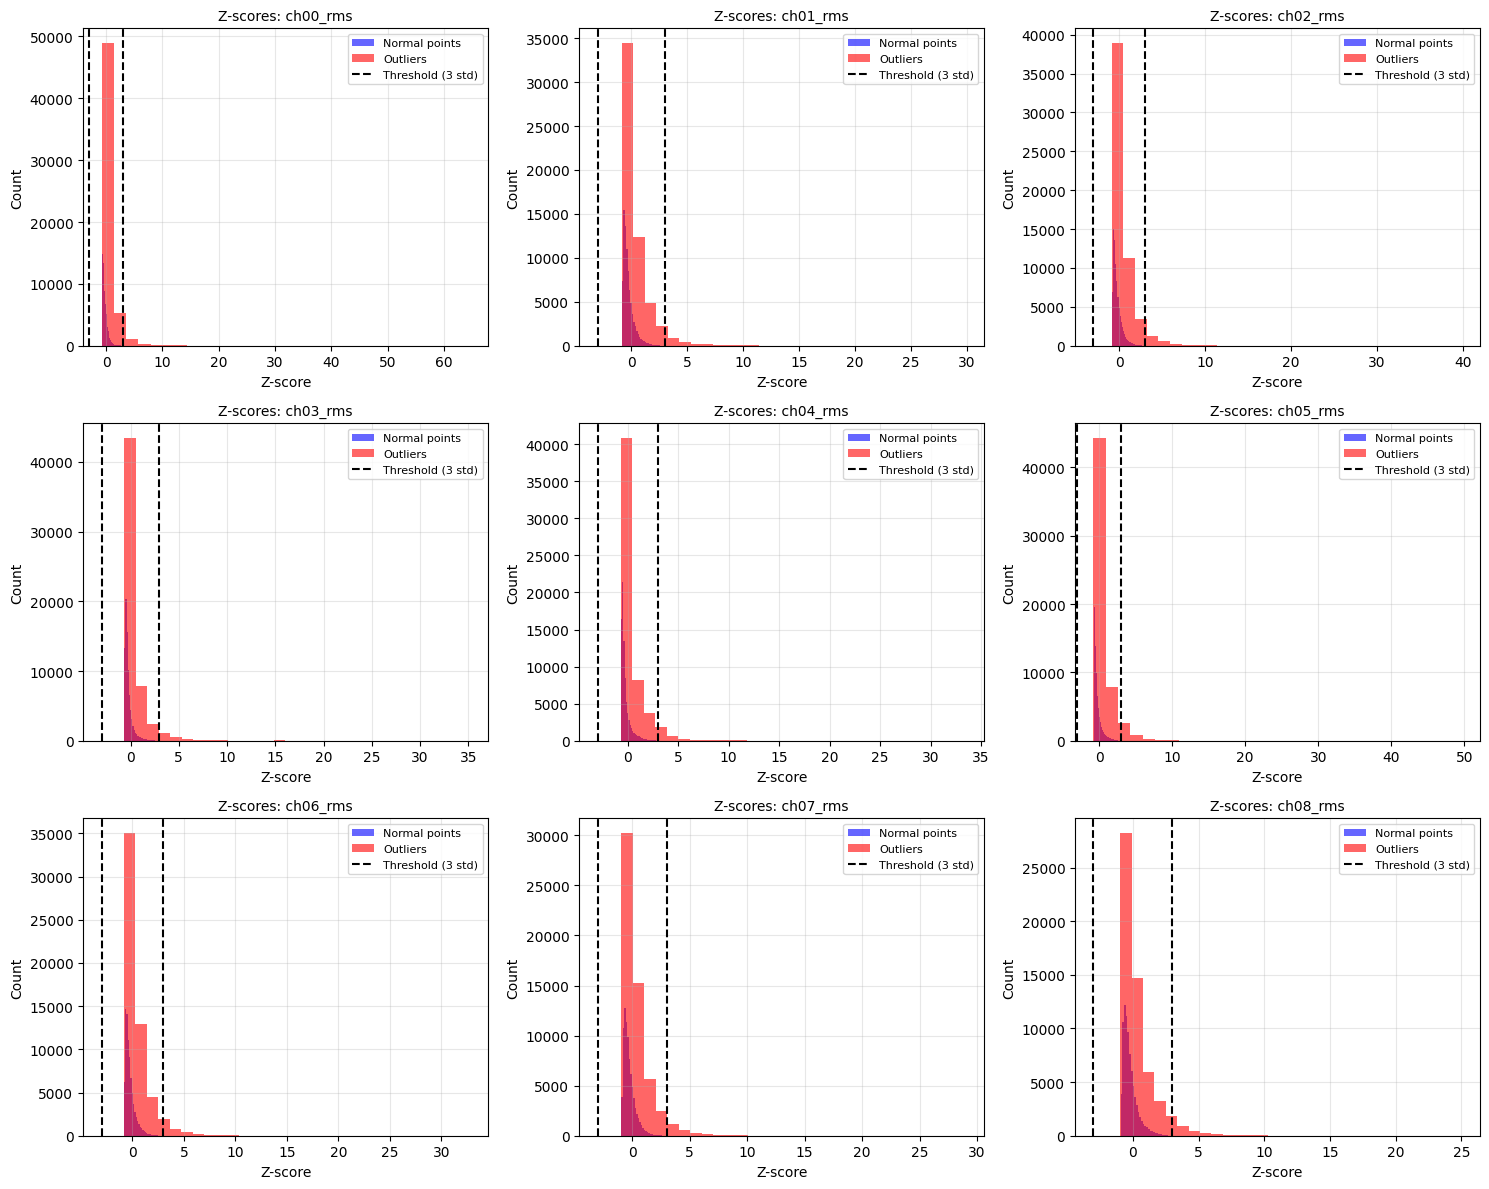

In [19]:
# Make plots for Z-score method

# look at the first 9 features for Z-score plots
features_to_plot_z = feature_cols[:9]

# Create 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()  # Convert 3x3 grid to 1D array for easy indexing

for i, feature in enumerate(features_to_plot_z):
    # Get Z-scores for this specific feature
    feature_z_scores = z_scores[feature]  # Get column by name
    
    # Separate normal points from outliers for this feature
    normal_z = feature_z_scores[~z_outlier_rows]
    outlier_z = feature_z_scores[z_outlier_rows]
    
    # Plot histogram of Z-scores
    axes[i].hist(normal_z, bins=30, color='blue', alpha=0.6, label='Normal points')
    axes[i].hist(outlier_z, bins=30, color='red', alpha=0.6, label='Outliers')
    
    # Add threshold lines
    axes[i].axvline(x=z_threshold, color='black', linestyle='--', label='Threshold (3 std)')
    axes[i].axvline(x=-z_threshold, color='black', linestyle='--')
    
    axes[i].set_title(f'Z-scores: {feature}', fontsize=10)
    axes[i].set_xlabel('Z-score')
    axes[i].set_ylabel('Count')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### By sklearn.ensemble.IsolationForest

In [20]:
# Method 2: Isolation Forest (machine learning approach)

iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=50)
iso_labels = iso_forest.fit_predict(X_data)

# -1 means outlier, 1 means normal
iso_outlier_rows = iso_labels == -1
iso_outlier_count = iso_outlier_rows.sum()
iso_outlier_percent = (iso_outlier_count / len(df_clean)) * 100

print(f"Isolation Forest found {iso_outlier_count} outliers ({iso_outlier_percent:.1f}% of data)")

# Add outlier information to our data
df_clean = df_clean.copy()  # makes a fresh copy to avoid warning
df_clean['is_outlier'] = iso_outlier_rows

Isolation Forest found 13938 outliers (10.0% of data)


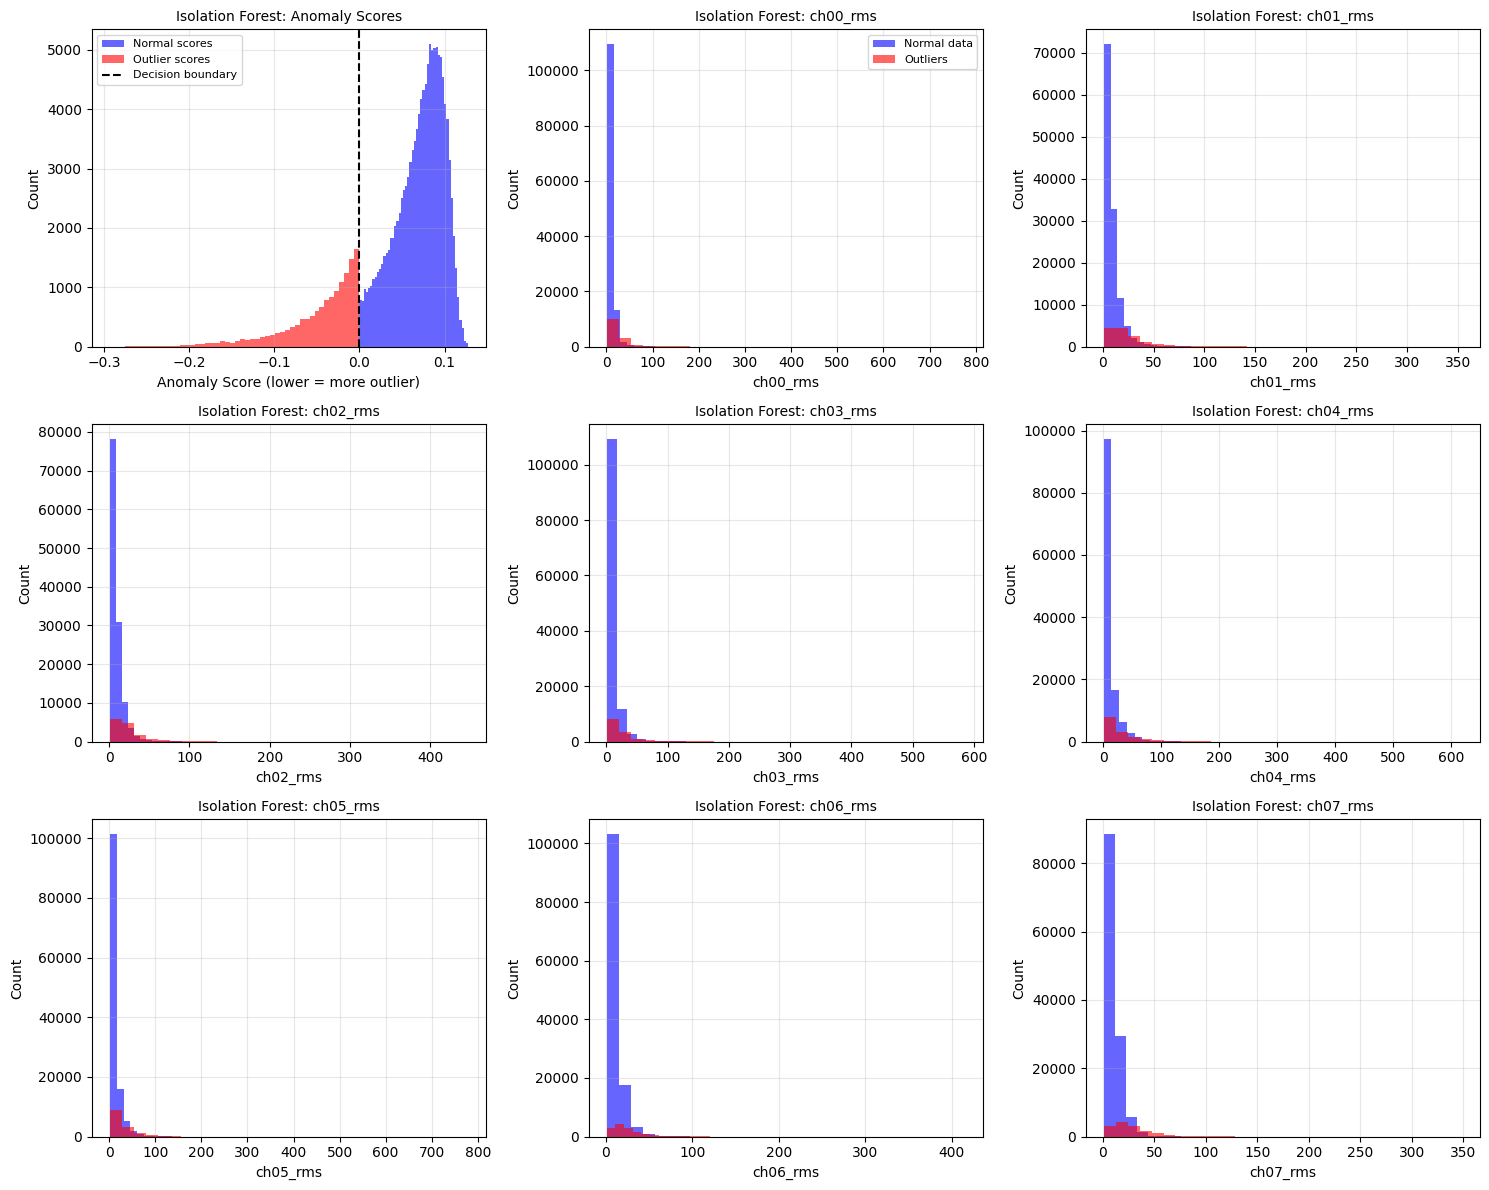

In [21]:
# Get anomaly scores (how outlier-ish each point is)
iso_scores = iso_forest.decision_function(X_data)

# Create 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Plot 1: Histogram of anomaly scores (top left)
axes[0].hist(iso_scores[~iso_outlier_rows], bins=50, color='blue', alpha=0.6, label='Normal scores')
axes[0].hist(iso_scores[iso_outlier_rows], bins=50, color='red', alpha=0.6, label='Outlier scores')
axes[0].axvline(x=0, color='black', linestyle='--', label='Decision boundary')
axes[0].set_title('Isolation Forest: Anomaly Scores', fontsize=10)
axes[0].set_xlabel('Anomaly Score (lower = more outlier)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot 2-9: Show 8 features with outliers highlighted
features_to_plot_iso = feature_cols[:8]  # First 8 features for remaining subplots

for i, feature in enumerate(features_to_plot_iso):
    # Get normal and outlier data for this feature
    normal_data = X_data.loc[~iso_outlier_rows, feature]
    outlier_data = X_data.loc[iso_outlier_rows, feature]
    
    # Create histograms to show distribution
    axes[i+1].hist(normal_data, bins=30, color='blue', alpha=0.6, label='Normal data')
    axes[i+1].hist(outlier_data, bins=30, color='red', alpha=0.6, label='Outliers')
    
    axes[i+1].set_title(f'Isolation Forest: {feature}', fontsize=10)
    axes[i+1].set_xlabel(feature)
    axes[i+1].set_ylabel('Count')
    axes[i+1].grid(True, alpha=0.3)
    
    # Add legend to first feature plot only to avoid clutter
    if i == 0:
        axes[i+1].legend(fontsize=8)

plt.tight_layout()
plt.show()

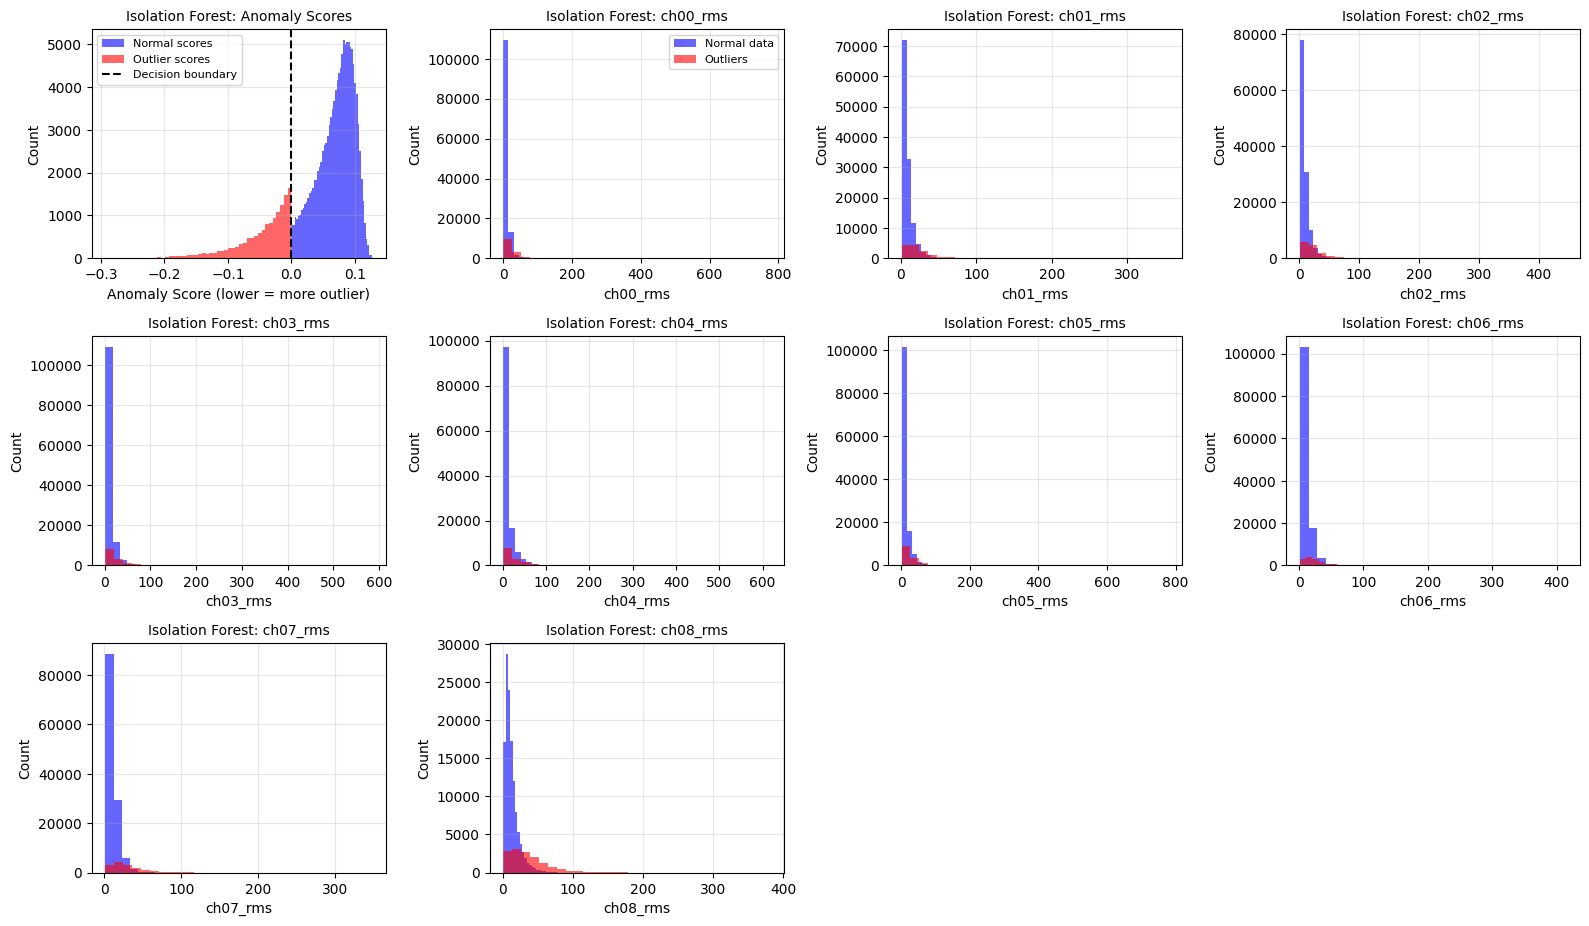

In [22]:
# Get anomaly scores and create plots with toggle functionality

# TOGGLE SETTINGS - Change these values as needed:
NUM_PLOTS = 9  # Options: 4, 9, 16, 25, 'all', etc.

# Determine how many features to plot (excluding anomaly score plot)
if NUM_PLOTS == 'all':
    features_to_plot_iso = feature_cols
    num_features = len(features_to_plot_iso)
else:
    num_features = min(NUM_PLOTS, len(feature_cols))
    features_to_plot_iso = feature_cols[:num_features]

# Grid calculation
import math
total_plots = num_features + 1  # Add 1 for the anomaly score plot
grid_size = math.ceil(math.sqrt(total_plots))  # Square root and round up
nrows, ncols = grid_size, grid_size  # Square grid

# Adjust figure size based on grid dimensions
fig_width = max(12, ncols * 4)   # Scale with columns
fig_height = max(8, nrows * 3)   # Scale with rows

# Create subplot grid
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
axes = axes.flatten()

# Plot 1: Histogram of anomaly scores (always first plot)
axes[0].hist(iso_scores[~iso_outlier_rows], bins=50, color='blue', alpha=0.6, label='Normal scores')
axes[0].hist(iso_scores[iso_outlier_rows], bins=50, color='red', alpha=0.6, label='Outlier scores')
axes[0].axvline(x=0, color='black', linestyle='--', label='Decision boundary')
axes[0].set_title('Isolation Forest: Anomaly Scores', fontsize=10)
axes[0].set_xlabel('Anomaly Score (lower = more outlier)')
axes[0].set_ylabel('Count')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot remaining features
for i, feature in enumerate(features_to_plot_iso):
    plot_index = i + 1  # Start from index 1 (index 0 is anomaly scores)
    
    if plot_index >= len(axes):  # Safety check
        break
        
    # Get normal and outlier data for this feature
    normal_data = X_data.loc[~iso_outlier_rows, feature]
    outlier_data = X_data.loc[iso_outlier_rows, feature]
    
    # Create histograms to show the distribution
    axes[plot_index].hist(normal_data, bins=30, color='blue', alpha=0.6, label='Normal data')
    axes[plot_index].hist(outlier_data, bins=30, color='red', alpha=0.6, label='Outliers')
    
    axes[plot_index].set_title(f'Isolation Forest: {feature}', fontsize=10)
    axes[plot_index].set_xlabel(feature)
    axes[plot_index].set_ylabel('Count')
    axes[plot_index].grid(True, alpha=0.3)
    
    # Add legend to first feature plot only to avoid clutter
    if i == 0:
        axes[plot_index].legend(fontsize=8)

# Hide any unused subplots
for i in range(total_plots, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### By boxplots via seaborn.boxplot

Boxplot method found 113587 outliers (81.5% of data)


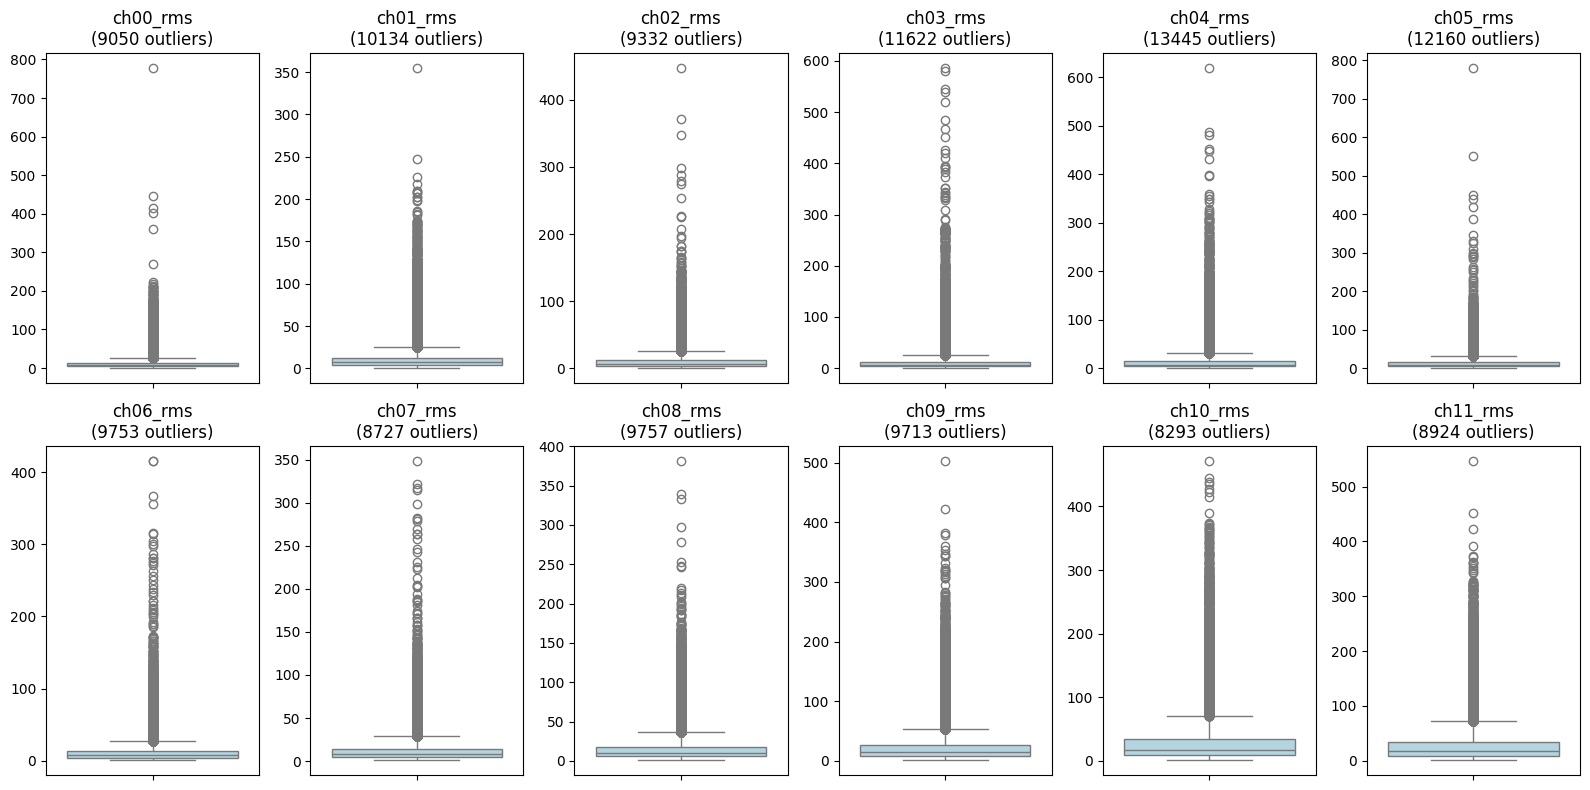

In [23]:
# Method 3: Boxplot/IQR method for outlier detection

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = X_data.quantile(0.25)
Q3 = X_data.quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries (1.5 * IQR is standard)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
box_outlier_flags = (X_data < lower_bound) | (X_data > upper_bound)
box_outlier_rows = box_outlier_flags.any(axis=1)

box_outlier_count = box_outlier_rows.sum()
box_outlier_percent = (box_outlier_count / len(df_clean)) * 100

print(f"Boxplot method found {box_outlier_count} outliers ({box_outlier_percent:.1f}% of data)")

# Make actual boxplots to show IQR method

# Let's make boxplots for the first X features
boxplot_features = feature_cols[:12]

fig, axes = plt.subplots(2, 6, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(boxplot_features):
    # Make boxplot
    sns.boxplot(y=X_data[feature], ax=axes[i], color='lightblue')
    
    # Add some information about this feature's outliers
    feature_outliers = box_outlier_flags[feature].sum()
    axes[i].set_title(f"{feature}\n({feature_outliers} outliers)")
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

### By gamma distribution

This method may be more appropriate for our EMG data since values are positive-only, and we expect a long-tailed distribution where muscle contractions create high values.

In [24]:
# Method 4: Gamma Distribution Outlier Detection

from scipy.stats import gamma

# Create DataFrame to track which points are outliers for each feature
# Start with all False (meaning no outliers yet)
gamma_outlier_flags = pd.DataFrame(index=X_data.index, columns=feature_cols, data=False)

# create dictionaries to store gamma parameters and thresholds
gamma_parameters = {}  # store k and theta for each feature
gamma_thresholds = {}  # store upper_threshold for each feature

# For each feature, fit gamma distribution and identify outliers
for i, feature in enumerate(feature_cols):
    
    # Get data for this specific feature
    feature_data = X_data[feature].values
    
    # Calculate mean and variance of feature data
    mean_val = np.mean(feature_data)
    var_val = np.var(feature_data)
    
    # Calculate gamma distribution parameters
    # k is shape parameter
    k = (mean_val ** 2) / var_val
    
    # theta is scale parameter
    theta = var_val / mean_val
    
    # Save these parameters for later use
    gamma_parameters[feature] = {'k': k, 'theta': theta}
    
    # Calculate outlier threshold using 99.5th percentile
    # i.e., only values higher than 99.5% of the data are considered outliers
    upper_threshold = gamma.ppf(0.995, k, scale=theta)
    
    # Save threshold for later use
    gamma_thresholds[feature] = upper_threshold
    
    # Find which data points are above this threshold (i.e., outliers)
    feature_outliers = feature_data > upper_threshold
    
    # Save these outlier flags to our DataFrame
    gamma_outlier_flags[feature] = feature_outliers

# Data sample (row) is considered an overall outlier if it has outliers in multiple features
# Use a threshold of 8 features (8/160 = 5% of features)
min_feats = 8

# Count how many features are outliers for each data sample
outlier_counts_per_sample = gamma_outlier_flags.sum(axis=1)

# Consider sample as an outlier if it has outliers in more than `min_feats` features
gamma_outlier_rows = outlier_counts_per_sample > min_feats

# Count how many total outliers found
gamma_outlier_count = gamma_outlier_rows.sum()

# Calculate percentage of data considered outliers
gamma_outlier_percent = (gamma_outlier_count / len(df_clean)) * 100

print(f"Gamma distribution method found {gamma_outlier_count} outliers ({gamma_outlier_percent:.1f}% of data)")

Gamma distribution method found 4078 outliers (2.9% of data)


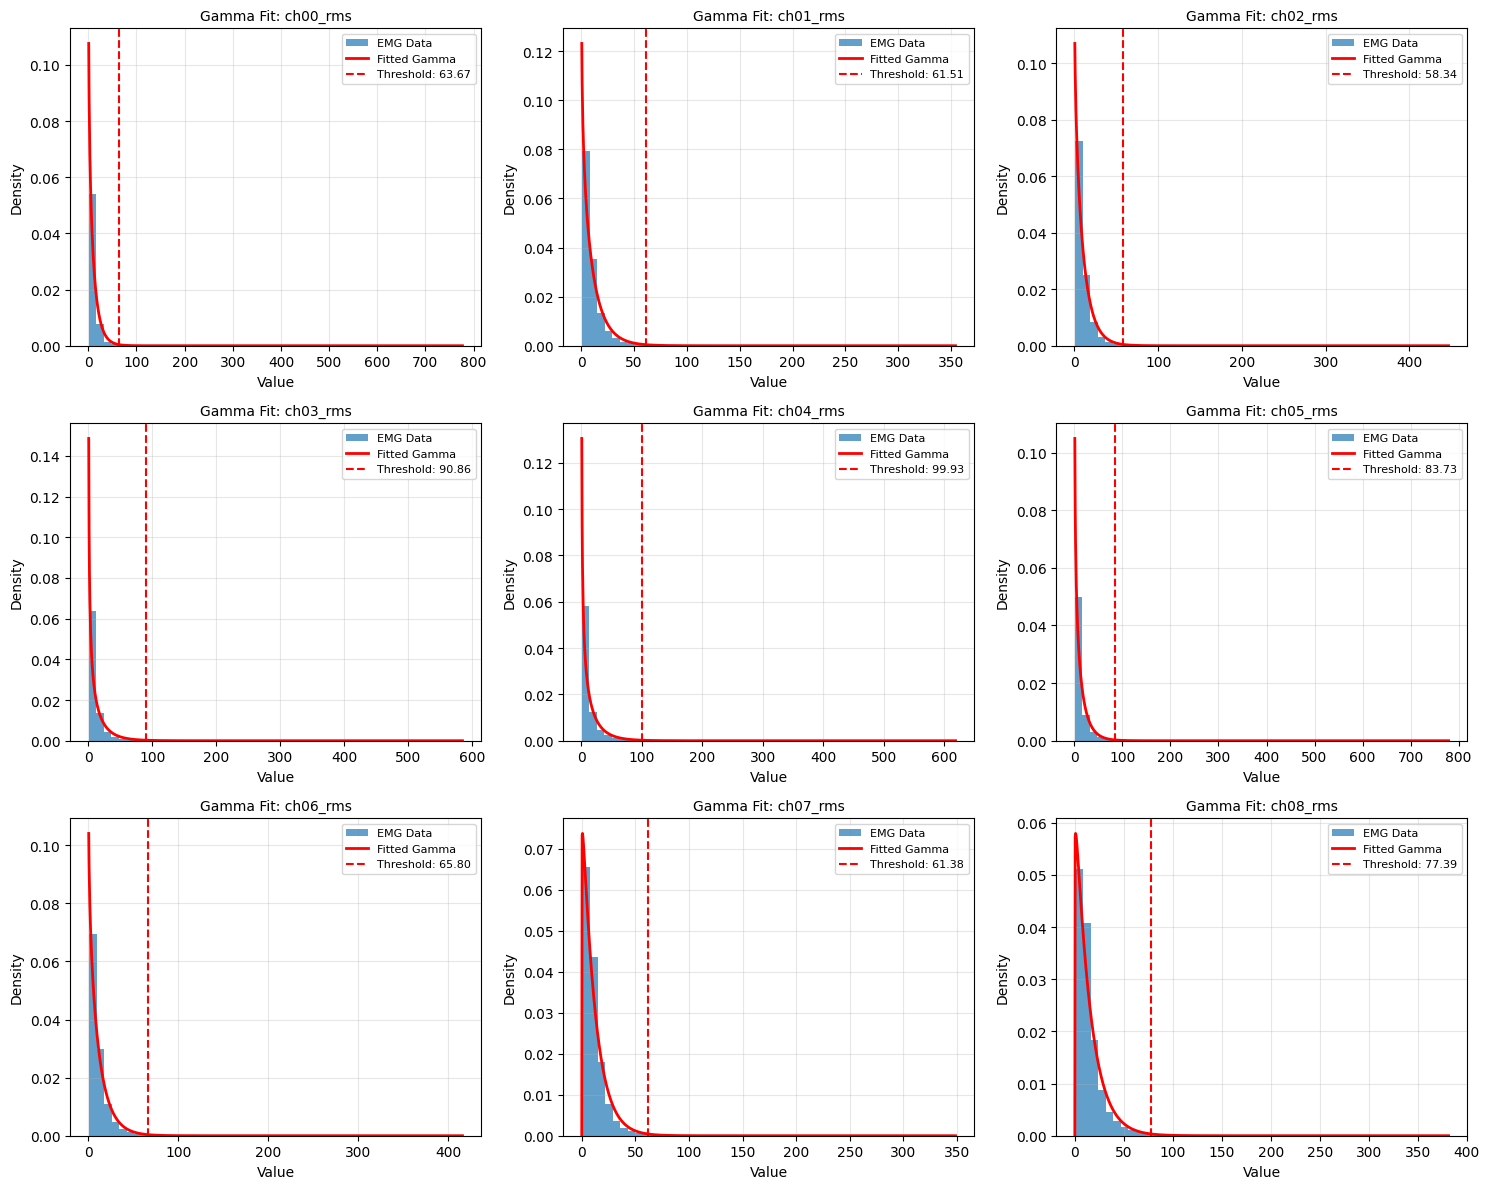

In [25]:
# Visualize gamma distribution fitting for multiple features - 3x3 grid
# Look at first 9 EMG features (or any other #)

features_to_plot_gamma = feature_cols[:9]  # First 9 features

# Create 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Loop through each feature and create plot
# NOW WE CAN USE THE SAVED PARAMETERS INSTEAD OF RECALCULATING!
for i, feature in enumerate(features_to_plot_gamma):
    # Get the data for this specific feature
    feature_data = X_data[feature].values
    
    # Get the parameters we already calculated (no need to recalculate!)
    k = gamma_parameters[feature]['k']
    theta = gamma_parameters[feature]['theta']
    upper_threshold = gamma_thresholds[feature]
    
    # Create histogram of actual data
    axes[i].hist(feature_data, bins=50, density=True, alpha=0.7, label='EMG Data')
    
    # Create fitted gamma distribution curve
    x = np.linspace(0, np.max(feature_data), 1000)
    y = gamma.pdf(x, k, scale=theta)
    axes[i].plot(x, y, 'r-', linewidth=2, label='Fitted Gamma')
    
    # Draw vertical line at outlier threshold
    axes[i].axvline(x=upper_threshold, color='red', linestyle='--', 
                   label=f'Threshold: {upper_threshold:.2f}')
    
    # Add titles and labels
    axes[i].set_title(f'Gamma Fit: {feature}', fontsize=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

# If less than 9 features, skip empty subplots
if len(features_to_plot_gamma) < 9:
    for i in range(len(features_to_plot_gamma), 9):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### Comparison


In [26]:
# Compare all four outlier detection methods

# Create a summary DataFrame
results_summary = pd.DataFrame({
    'Method': ['Z-score', 'Isolation Forest', 'Boxplot (IQR)', 'Gamma Distribution'],
    'Outliers': [z_outlier_count, iso_outlier_count, box_outlier_count, gamma_outlier_count],
    'Percentage': [z_outlier_percent, iso_outlier_percent, box_outlier_percent, gamma_outlier_percent],
})

# Display table
print(results_summary.to_string(index=False))

            Method  Outliers  Percentage
           Z-score     55901   40.107765
  Isolation Forest     13938   10.000215
     Boxplot (IQR)    113587   81.496230
Gamma Distribution      4078    2.925877


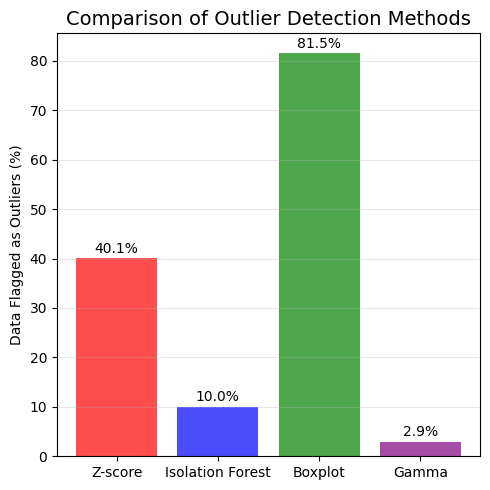

In [27]:
# Plot comparison of all four outlier detection methods
methods = ['Z-score', 'Isolation Forest', 'Boxplot', 'Gamma']
percents = [z_outlier_percent, iso_outlier_percent, box_outlier_percent, gamma_outlier_percent]
colors = ['red', 'blue', 'green', 'purple']

plt.figure(figsize=(5,5))
bars = plt.bar(methods, percents, color=colors, alpha=0.7)
plt.title('Comparison of Outlier Detection Methods', fontsize=14)
plt.ylabel('Data Flagged as Outliers (%)')
plt.grid(axis='y', alpha=0.3)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Check relationships between features and gestures

In [28]:
# Remove outliers using Gamma distribution method (most appropriate for our data)
df_no_outliers = df_clean[~gamma_outlier_rows].copy()
print(f"Original data shape: {df_clean.shape}")
print(f"Data after Gamma-based outlier removal: {df_no_outliers.shape}")
print(f"Removed {gamma_outlier_count} outliers ({gamma_outlier_percent:.1f}% of data)")

# Store which method we used for outlier removal
df_no_outliers.attrs['outlier_method'] = 'gamma_distribution'
df_no_outliers.attrs['outliers_removed'] = gamma_outlier_count
df_no_outliers.attrs['outlier_percentage'] = gamma_outlier_percent

Original data shape: (139377, 164)
Data after Gamma-based outlier removal: (135299, 164)
Removed 4078 outliers (2.9% of data)


## Save cleaned data

In [29]:
# Save cleaned data for feature selection notebook
# output_path = "../../emg_data/features_emg_data_cleaned.csv"
output_path = "../data/processed/features_emg_data_cleaned.csv"
df_no_outliers.to_csv(output_path, index=False)
print(f"Saved cleaned data to: {output_path}")

Saved cleaned data to: ../data/processed/features_emg_data_cleaned.csv
